<a href="https://colab.research.google.com/github/kellyshreeve/farm_vs_solar_img_classifier/blob/main/Farm_vs_Solar_Field_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Farm vs. Solar Field Image Classifier**

### 1. Install Packages

In [1]:
!pip install -Uqq fastai duckduckgo_search

In [2]:
from duckduckgo_search import DDGS

from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

from time import sleep

### 2. Get Images

In [3]:
def search_images(term, max_images=30):
  '''Takes a search term and number of images and returns
  a list of image urls of length max_images.

  term: search term for internet image search
  max_images: total images urls to return.'''
  print(f"Searching for images of '{term}'")
  with DDGS() as ddgs:
        images_gen = ddgs.images(
            keywords=term,
            max_results=max_images
        )
        return L(images_gen).itemgot('image')

Searching for images of 'farm field aerial'


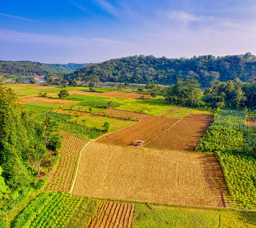

In [4]:
# Download a single image of a farm
urls = search_images('farm field aerial', 1)

dest = 'farm.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

Searching for images of 'solar field aerial'


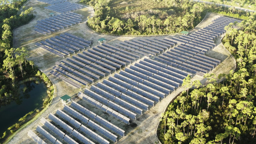

In [5]:
# Download a single image of a solar field
download_url(search_images('solar field aerial', 1)[0], 'solar field.jpg', show_progress=False)

Image.open('solar field.jpg').to_thumb(256, 256)


In [25]:
# Search varying images in sun and shade
search_terms = 'farm field', 'solar field'
path = Path('farm_or_solar_aerial_100')

for o in search_terms:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} aerial photo', max_images=100))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} aerial sun photo', max_images=100))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} aerial shade photo', max_images=100))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

Searching for images of 'farm field aerial photo'
Searching for images of 'farm field aerial sun photo'
Searching for images of 'farm field aerial shade photo'
Searching for images of 'solar field aerial photo'
Searching for images of 'solar field aerial sun photo'
Searching for images of 'solar field aerial shade photo'


### 3. Train Model

In [26]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

len(failed)

10

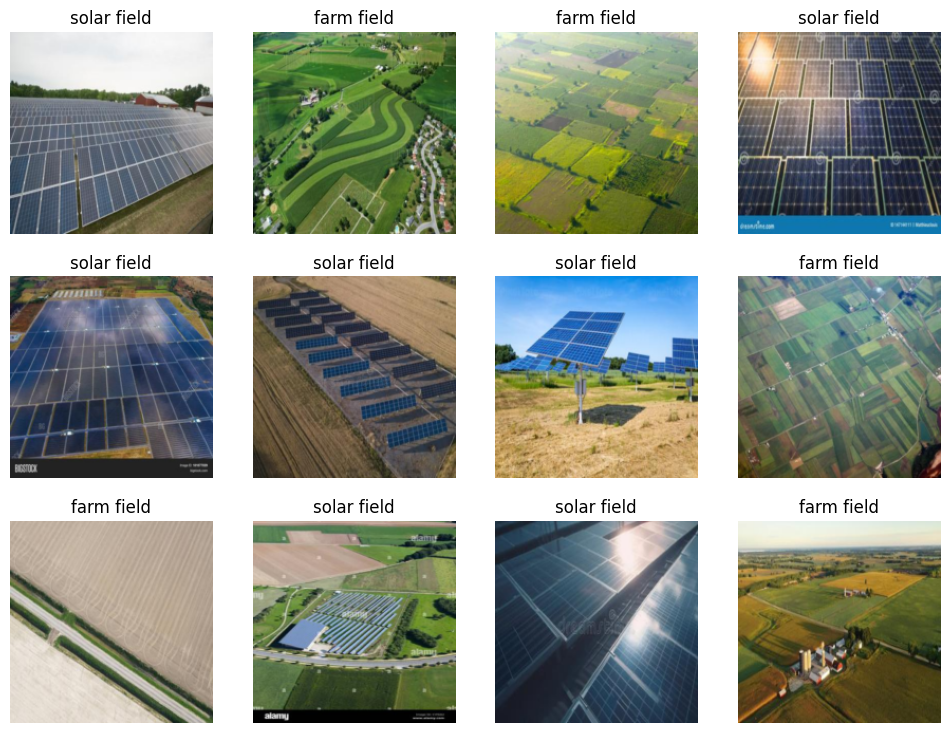

In [27]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=.2, seed=123),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [14]:
nueral_net = vision_learner(dls, resnet18, metrics=error_rate)
nueral_net.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.130872,0.400622,0.151515,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.350006,0.194673,0.030303,00:01
1,0.214825,0.040129,0.000000,00:01
2,0.162352,0.036105,0.000000,00:01


### 4. Test Model

Test Image


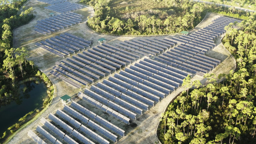


Model Prediction:

This is a: solar field.
Probability it's a solar field: 0.9999


In [24]:
is_farm,_,proba = nueral_net.predict(PILImage.create('solar field.jpg'))

print('Test Image')
display(Image.open('solar field.jpg').to_thumb(256, 256))
print()

print('Model Prediction:')
print()
print(f"This is a: {is_farm}.")
print(f"Probability it's a solar field: {1-proba[0]:.4f}")

Test Image


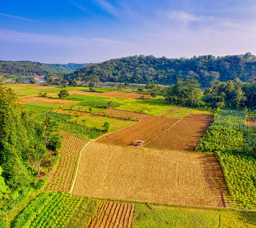


Model Prediction:

This is a: farm field.
Probability it's a farm field: 0.9905


In [29]:
is_farm,_,proba = nueral_net.predict(PILImage.create('farm.jpg'))

print('Test Image')
display(Image.open('farm.jpg').to_thumb(256, 256))
print()

print('Model Prediction:')
print()
print(f"This is a: {is_farm}.")
print(f"Probability it's a farm field: {proba[0]:.4f}")